In [ ]:
import math
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import num_methods as nm
from drawing import *

In [ ]:
# TODO: remove list, можно использовать предыдущее значение
def newtonsMethod(a, c, T, y, b, x):
    l = [x]  # list of x(y) values
    for _ in range(100):
        xn = l[-1]  # previous value of x
        y_x = ((-xn+c)*T+y)/(1+b*T)  # y выраженный через х

        f = -xn+(-a*(xn**3/3-xn) + a*y_x)*T+x  # вот это есть в классе
        g = -1+a*T*(-T/(b*T+1)-xn**2+1)

        l.append(l[-1] - f/g)
    return l[-1]

In [ ]:
"""Неявный метод Эйлера 1-го порядка"""
def implicit_method(T, a, xvn, yvn, c, b):
    xn2 = newtonsMethod(a, c, T, yvn, b, xvn)
    yn2 = (T*(-xn2+c) + yvn)/(1+b*T)
    return (xn2, yn2)

[scipy root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html),
[Jacobian](<https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Vector_Calculus/3%3A_Multiple_Integrals/3.8%3A_Jacobians>)


In [ ]:
"""Неявный метод Хаммера-Холлингсворта 4-го порядка"""
def implicit2_method(T, ak, xvn, yvn, ck, bk):
     # Таблица Бутчера
     a = [[1/4, 1/4 - math.sqrt(3)/6],
          [1/4 + math.sqrt(3)/6, 1/4]]
     c = [(1/2 - math.sqrt(3)/6), 1/2 + math.sqrt(3)/6]
     b = [1/2, 1/2]

     # x[0] = kx1, x[1] = kx2
     def fkx(x):
          xvn1 = xvn + T * (a[0][0] * x[0] + a[0][1] * x[1])
          xvn2 = xvn + T * (a[1][0] * x[0] + a[1][1] * x[1])
          # т.к. уравнения равны нулю, вычитаем kx1 и kx2
          return [-ak * ((xvn1) ** 3 / 3 - xvn1 - (yvn + c[0] * T)) - x[0],
                  -ak * ((xvn2) ** 3 / 3 - xvn2 - (yvn + c[1] * T))- x[1]]
     
     def jac_fkx(x):
          xvn1 = xvn + T * (a[0][0] * x[0] + a[0][1] * x[1])
          xvn2 = xvn + T * (a[1][0] * x[0] + a[1][1] * x[1])
          # Якобиан системы, частные производные от каждого
          # уравнения по каждой переменной
          return np.array([[-ak * ((xvn1) ** 2 * T * a[0][0] - T * a[0][0]) - 1,
                          -ak * ((xvn1) ** 2 * T * a[0][1] - T * a[0][1])],
                          [-ak * ((xvn2) ** 2 * T * a[1][0] - T * a[1][0]),
                          -ak * ((xvn2) ** 2 * T * a[1][1] - T * a[1][1]) - 1]])


     sol = optimize.root(fun=fkx, x0=[0, 0],
                         jac=jac_fkx, method='hybr')
     xn = xvn + T * (b[0] * sol.x[0] + b[1] * sol.x[1])

     # y[0] = ky1, y[1] = ky2
     def fky(y):
          yvn1 = yvn + T * (a[0][0] * y[0] + a[0][1] * y[1])
          yvn2 = yvn + T * (a[1][0] * y[0] + a[1][1] * y[1])
          return [-(xvn + c[0] * T) - bk * yvn1 + ck - y[0],
                  -(xvn + c[1] * T) - bk * yvn2 + ck - y[1]]
     
     def jac_fky(y):
          return np.array([[-bk * T * a[0][0] - 1, -bk * T * a[0][1]],
                           [-bk * T * a[1][0], -bk * T * a[1][1] - 1]])

     sol = optimize.root(fun=fky, x0=[0, 0],
                         jac=jac_fky, method='hybr')
     yn = yvn + T * (b[0] * sol.x[0] + b[1] * sol.x[1])

     return (xn, yn)

$x' = -a(\frac{x^3}{3} - x) - ay$\
$y' = -x - by + c$\
$x(0) = 2,\quad y(0) = 0$\
Здесь 1 $\leq$ _a_ $\leq$ 10^3, 0 < _c_ < 1.
Провести исследование поведения решений в зависимости от значений «большого» параметра _a_.


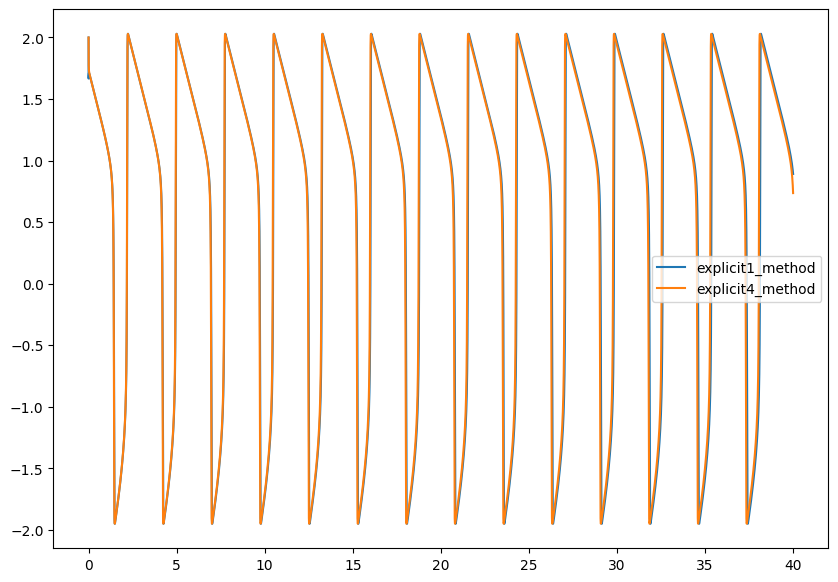

In [46]:
from num_methods import Solver2
from drawing import draw


def fx(xvn, yvn, a, b, c):
    return -a*((xvn**3)/3-xvn) + a*yvn

def fy(xvn, yvn, a, b, c):
    return -xvn + c - b*yvn


sol = Solver2((fx, fy), [50, 0.5, 0.6], (2, 0), (0, 40))

array1 = sol.do_method(sol.explicit1_method, 0.01)
array2 = sol.do_method(sol.explicit4_method, 0.01)

arrayx1 = [i[0] for i in array1[1]]
arrayx2 = [i[0] for i in array2[1]]

# main_array.append(arrayx3)
# print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
# array_dif_x3 = [[i[0] for i in array3_dif]]
draw([array1[0], array2[0]],
     [arrayx1, arrayx2],
     [array1[3], array2[3]])
# draw([[i[0] for i in array2[2]]], [arrayx2], ["x' from x"])

### Сравнение с решением с помощью SciPy


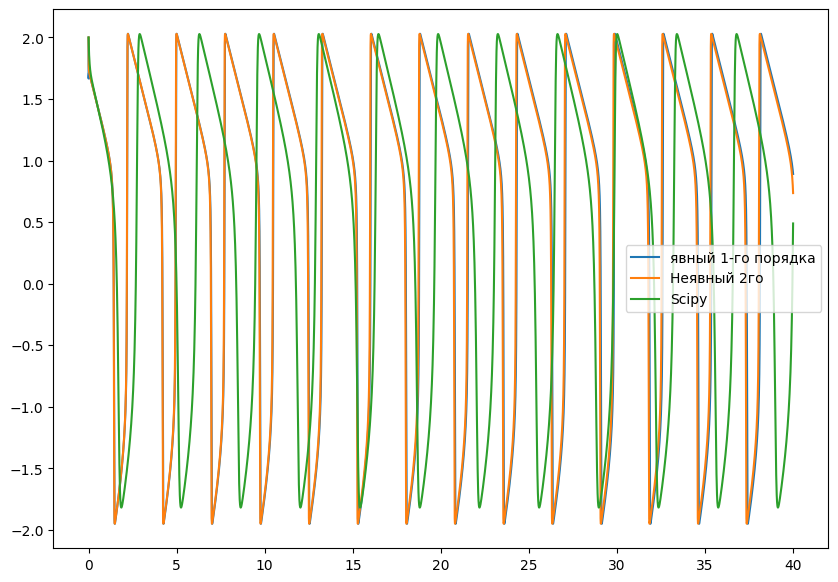

In [47]:
from scipy.integrate import ode

def f(t, y, a, b, c):
  return [a*(y[0] + y[1] - y[0]**3/3),
          c - y[0] - b*y[1]]

def jac(t, y, a, b, c):
  return [[a*(1 - y[0]**2),  a],
          [             -1, -b]]

y01, y02 = 2., 0.
a, b, c = 10, 0.5, 0.5
r = ode(f, jac).set_integrator('vode', method='adams', with_jacobian=True)
r.set_initial_value((y01, y02)).set_f_params(a, b, c).set_jac_params(a, b, c)

t1, dt, t, y1, y2 = 40, 0.01, [0.], [y01], [y02]
while r.successful() and r.t < t1:
  r.integrate(r.t + dt)
  t.append(r.t)
  y1.append(r.y[0])
  y2.append(r.y[1])

draw([array1[0], array2[0], t],
     [arrayx1, arrayx2, y1],
      [f"явный 1-го порядка", "Неявный 2го", f"Scipy"])

Веселые рисунки


AttributeError: module 'num_methods' has no attribute 'Solverdo_method'

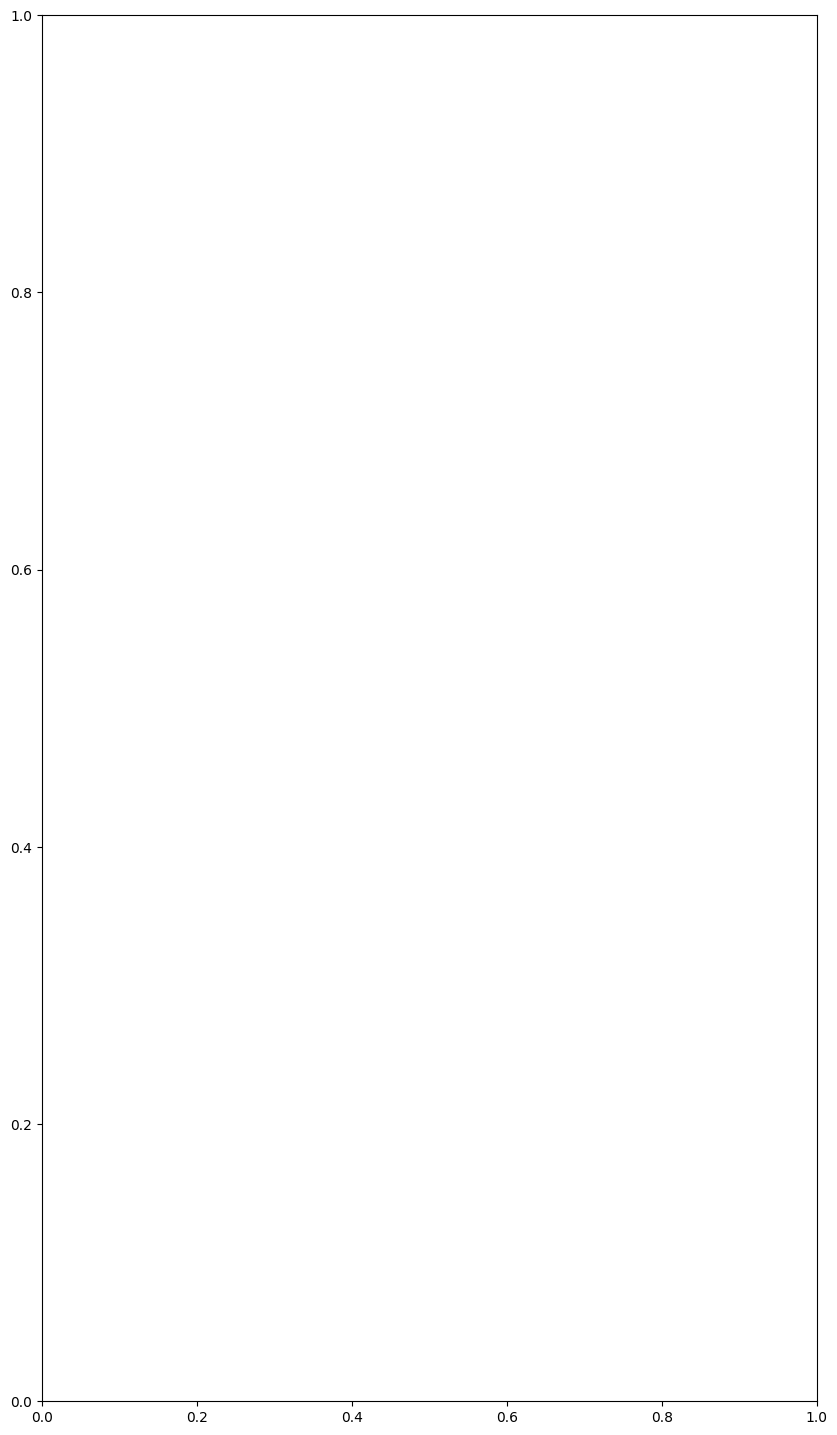

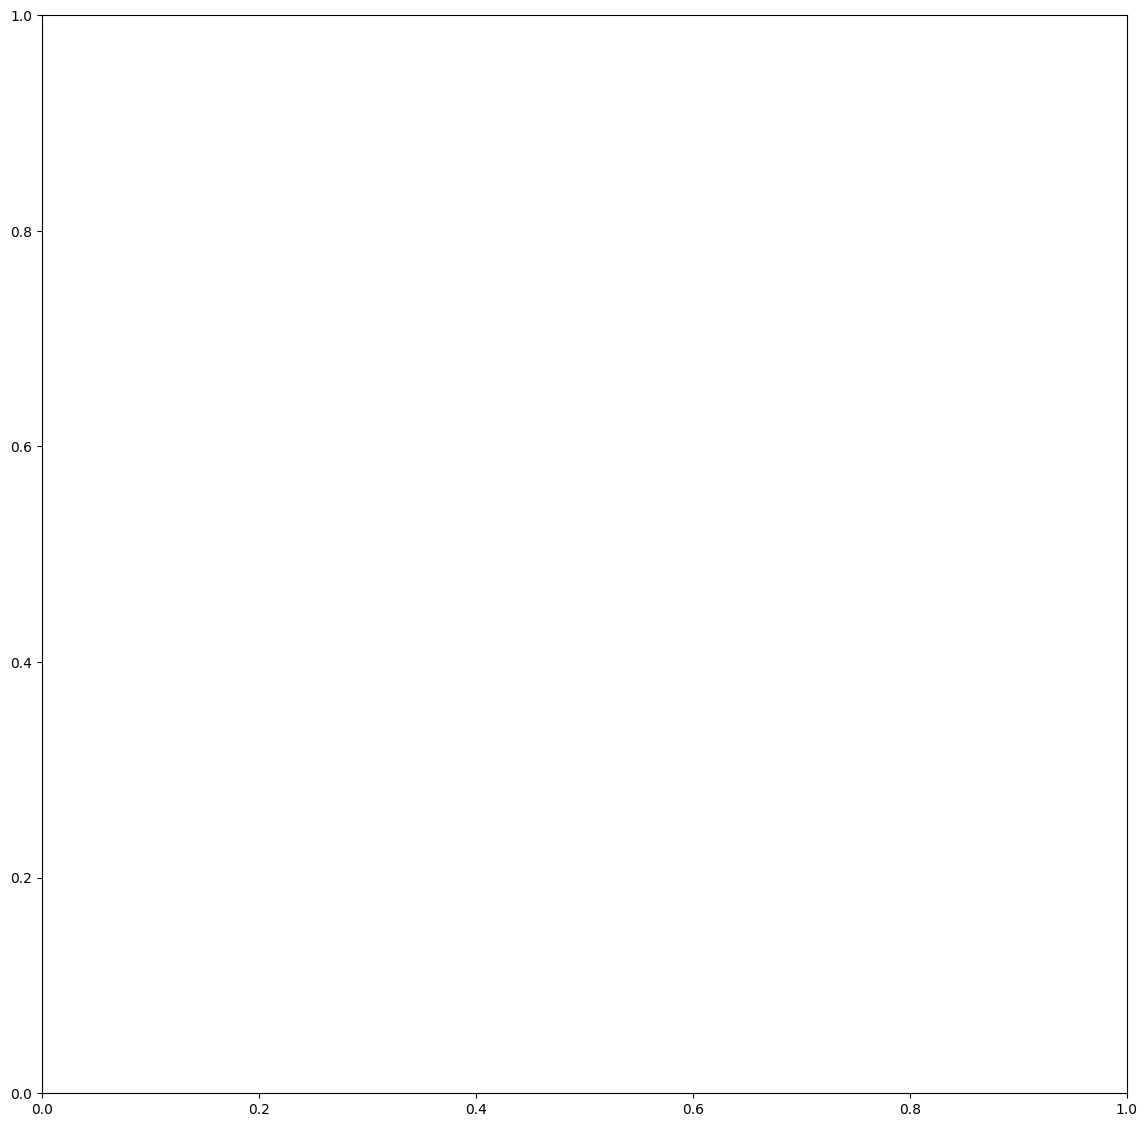

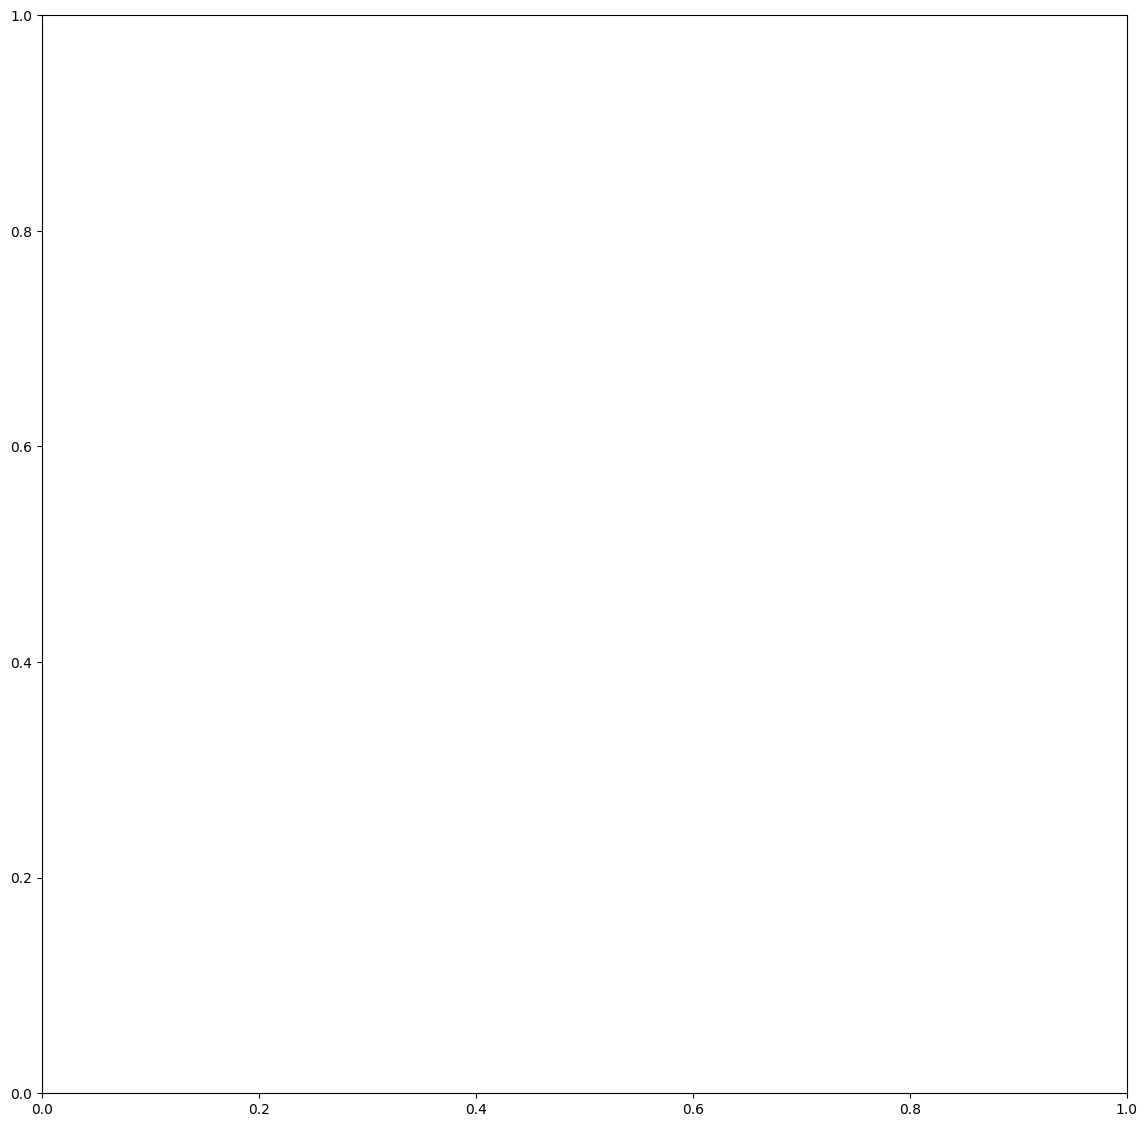

In [48]:
T = 0.01
t_start = 0
t_finish = 40
a = 1
fig1 = plt.figure(figsize=(10,18))
px1 = fig1.add_subplot(111)
fig2 = plt.figure(figsize=(14, 14))
px2 = fig2.add_subplot(111)
fig3 = plt.figure(figsize=(14, 14))
px3 = fig3.add_subplot(111)
while a <= 32:
    c = 0.5
    b = 0.60
    # Первый элемент это x, второй y
    variables = (T, a, b, c)
    array0 = [(2, 0)]
    array1 = nm.Solverdo_method(explicit_method, t_start, t_finish, [t_start], [(2, 0)], variables)
    array2 = nm.do_method(implicit2_method, t_start, t_finish, [t_start], [(2, 0)], variables)

    arrayx1 = [i[0] for i in array1[1]]
    arrayx2 = [i[0] for i in array2[1]]

    # main_array.append(arrayx3)
    # print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
    # array_dif_x3 = [[i[0] for i in array3_dif]]
    # draw([array1[0], array2[0]],
    #     [arrayx1, arrayx2],
    #     [f"явный 1-го порядка {len(array1[0])}", f"неявный 2го"])
    draw_on_plot([arrayx2], [[i[0] for i in array2[2]]], [f"{a} value"], px1)
    # draw([[i[0] for i in array2[2]]], [arrayx2], [f"{a} value"])
    draw_on_plot([[i[1] for i in array2[1]]], [[i[1] for i in array2[2]]], [f"{a} value"], px2)
    draw_on_plot([arrayx2], [[i[1] for i in array2[1]]], [f"a value: {a}"], px3)
    a *= 1.2
px1.legend()
px2.legend()
px3.legend()